# UK used cars price (lightGBM regressor)

In [1]:
import sys
import math
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact

sns.set_style('darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
print(f'Python  version: {sys.version}')
print(f'pandas  version: {pd.__version__}')
print(f'numpy   version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

pd.Timestamp.now()
# pd.Timestamp.now().strftime('%Y-%m-%d')

Python  version: 3.8.2 (default, Mar 26 2020, 10:43:30) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
pandas  version: 1.2.5
numpy   version: 1.20.2
seaborn version: 0.11.1


Timestamp('2021-06-30 04:43:30.878767')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from datetime import datetime
import socket # pip install socket

print(f'last run: {datetime.now()}')

try:
    print(f'ip addtress: {socket.gethostbyname(socket.gethostname())} ({socket.gethostname()})')
except:
    pass

last run: 2021-06-30 04:43:30.908742
ip addtress: 127.0.0.1 (Guy.local)


utility functions

In [5]:
def df_unique_value(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            print(f'{c:10}\n{df[c].unique()}')
            print('-' * 65)
            
def convert_cols_to_category(df, cols:list):
    """
    convert `cols` to `category`
    """
    for c in df[cols]:
        df[c] = df[c].astype('category')
    return df
    
def convert_obj_columns_to_category(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df[c] = df[c].astype('category')
    return df

def print_category_columns(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type.name == 'category':
    #         print(f'{c}: {df[c].cat.categories}')
    #         print(pd.Series(df[c].cat.categories))
            print(f'{c:15}: {list(enumerate(df[c].cat.categories))}')
            print('-' * 60)
            
def plot_mn(df, cols, n_rows:int=1, kind:str='boxplot', color='salmon'):
    """
    plot boxplot, violin, hist in m (rows) by n (columns)
    >>> plot_mn(df, ['Calories', 'Fat'], 2, 'hist')
    """
    n=len(cols)
    n_cols=math.ceil(n / n_rows)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3.5))
    ax=ax.ravel()

    fig.tight_layout()
    for i, c in enumerate(cols):
        col_type = df[c].dtype
        if col_type.name == 'category':
            sns.countplot(data=df, x=c, ax=ax[i])
        else:
            if kind.lower()=='boxplot':
                sns.boxplot(data=df[[c]], ax=ax[i], color=color)   
            if kind.lower()=='boxen':
                sns.boxenplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='violin':
                sns.violinplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='hist':
                sns.distplot(df[c], hist=True, kde=False, ax=ax[i], color=color)  
            

# คำถาม
1. วิเคราะห์และสำรวจข้อมูลเบื้องต้น 
1. การทำความสะอาดข้อมูล 
1. ตั้งประเด็นคำถามที่น่าสนใจพร้อมสร้าง machine learning model เพื่อตอบคำถาม

* อ่านข้อมูลจาก `https://github.com/prasertcbs/basic-dataset/tree/master/q2`

In [6]:
mfg=['bmw', 'vw', 'ford', 'toyota', 'hyundi']
dfs=[]
for f in mfg:
    url=f'https://github.com/prasertcbs/basic-dataset/raw/master/q2/{f}.csv'
    print(url)
    dt=pd.read_csv(url, skipinitialspace=True)
    dt['mfg']=f
    dfs.append(dt)
df=pd.concat(dfs)
df

https://github.com/prasertcbs/basic-dataset/raw/master/q2/bmw.csv
https://github.com/prasertcbs/basic-dataset/raw/master/q2/vw.csv
https://github.com/prasertcbs/basic-dataset/raw/master/q2/ford.csv
https://github.com/prasertcbs/basic-dataset/raw/master/q2/toyota.csv
https://github.com/prasertcbs/basic-dataset/raw/master/q2/hyundi.csv


,model,year,price,transmission,mileage,fuelType,mpg,engineSize,mfg
0,3 Series,2017.0,14990,Semi-Auto,48604.0,Diesel,67.3,2.0,bmw
1,2 Series,2020.0,26490,Semi-Auto,10.0,Diesel,47.1,2.0,bmw
2,X3,2019.0,38900,Semi-Auto,3302.0,Diesel,48.7,3.0,bmw
3,1 Series,2019.0,17980,Semi-Auto,10672.0,Diesel,74.3,2.0,bmw
4,3 Series,2015.0,11995,Semi-Auto,52385.0,Petrol,47.1,2.0,bmw
...,...,...,...,...,...,...,...,...,...
1495,I40,2017.0,10995,Manual,30000.0,Diesel,67.3,1.7,hyundi
1496,I10,2017.0,6490,Manual,26908.0,Petrol,60.1,1.0,hyundi
1497,Ioniq,2018.0,15000,Automatic,13727.0,Hybrid,78.5,1.6,hyundi
1498,Tucson,2016.0,11495,Manual,19312.0,Diesel,61.7,1.7,hyundi


# 1.ทำความสะอาดข้อมูล

## จากคอลัมน์ mileage และ mpg เราจะแปลงหน่วย mile ให้กลายเป็น kilometer 
- mileage หมายความว่า รถยนต์คันนั้นเคยถูกขับมาแล้วกี่ mile
- mpg หมายความว่า mile per galon เป็นอัตราการใช้น้ำมันของรถยนต์คันนั้น

In [7]:
df['mileage_km']=df['mileage']*1.60934

In [8]:
df['kml']=df['mpg']*0.4251437075
df

,model,year,price,transmission,mileage,fuelType,mpg,engineSize,mfg,mileage_km,kml
0,3 Series,2017.0,14990,Semi-Auto,48604.0,Diesel,67.3,2.0,bmw,78220.36136,28.612172
1,2 Series,2020.0,26490,Semi-Auto,10.0,Diesel,47.1,2.0,bmw,16.09340,20.024269
2,X3,2019.0,38900,Semi-Auto,3302.0,Diesel,48.7,3.0,bmw,5314.04068,20.704499
3,1 Series,2019.0,17980,Semi-Auto,10672.0,Diesel,74.3,2.0,bmw,17174.87648,31.588177
4,3 Series,2015.0,11995,Semi-Auto,52385.0,Petrol,47.1,2.0,bmw,84305.27590,20.024269
...,...,...,...,...,...,...,...,...,...,...,...
1495,I40,2017.0,10995,Manual,30000.0,Diesel,67.3,1.7,hyundi,48280.20000,28.612172
1496,I10,2017.0,6490,Manual,26908.0,Petrol,60.1,1.0,hyundi,43304.12072,25.551137
1497,Ioniq,2018.0,15000,Automatic,13727.0,Hybrid,78.5,1.6,hyundi,22091.41018,33.373781
1498,Tucson,2016.0,11495,Manual,19312.0,Diesel,61.7,1.7,hyundi,31079.57408,26.231367


In [9]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         7380 non-null   object 
 1   year          7380 non-null   float64
 2   price         7500 non-null   int64  
 3   transmission  7440 non-null   object 
 4   mileage       7320 non-null   float64
 5   fuelType      7320 non-null   object 
 6   mpg           7440 non-null   float64
 7   engineSize    7320 non-null   float64
 8   mfg           7500 non-null   object 
 9   mileage_km    7320 non-null   float64
 10  kml           7440 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 703.1+ KB


## จากการดู Data info แล้วพบว่า
- มีข้อมูลทั้งหมด 7500 แถว 10 คอลัมน์
- ข้อมูลส่วนใหญ่มีจำนวน missing value เราจึงทำการลบออก
- เพื่อความรอบคอบว่าจะมีข้อมูลที่ซ้ำกัน เราจึงจะทำการ drop duplicate
- เปลี่ยนคอลัมน์ที่มี Dtype เป็น object ให้กลายเป็น category เพื่อให้สามารถทำ count plot ได้สะดวก

In [10]:
df=df.dropna().reset_index(drop=True).copy()
df

,model,year,price,transmission,mileage,fuelType,mpg,engineSize,mfg,mileage_km,kml
0,3 Series,2017.0,14990,Semi-Auto,48604.0,Diesel,67.3,2.0,bmw,78220.36136,28.612172
1,2 Series,2020.0,26490,Semi-Auto,10.0,Diesel,47.1,2.0,bmw,16.09340,20.024269
2,X3,2019.0,38900,Semi-Auto,3302.0,Diesel,48.7,3.0,bmw,5314.04068,20.704499
3,1 Series,2019.0,17980,Semi-Auto,10672.0,Diesel,74.3,2.0,bmw,17174.87648,31.588177
4,3 Series,2015.0,11995,Semi-Auto,52385.0,Petrol,47.1,2.0,bmw,84305.27590,20.024269
...,...,...,...,...,...,...,...,...,...,...,...
6628,I10,2017.0,7495,Manual,27894.0,Petrol,60.1,1.0,hyundi,44890.92996,25.551137
6629,I40,2017.0,10995,Manual,30000.0,Diesel,67.3,1.7,hyundi,48280.20000,28.612172
6630,I10,2017.0,6490,Manual,26908.0,Petrol,60.1,1.0,hyundi,43304.12072,25.551137
6631,Ioniq,2018.0,15000,Automatic,13727.0,Hybrid,78.5,1.6,hyundi,22091.41018,33.373781


In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.drop(columns=['mpg','mileage'],inplace=True)

In [13]:
df.isna().sum()

model           0
year            0
price           0
transmission    0
fuelType        0
engineSize      0
mfg             0
mileage_km      0
kml             0
dtype: int64

In [14]:
df=convert_obj_columns_to_category(df)
df

,model,year,price,transmission,fuelType,engineSize,mfg,mileage_km,kml
0,3 Series,2017.0,14990,Semi-Auto,Diesel,2.0,bmw,78220.36136,28.612172
1,2 Series,2020.0,26490,Semi-Auto,Diesel,2.0,bmw,16.09340,20.024269
2,X3,2019.0,38900,Semi-Auto,Diesel,3.0,bmw,5314.04068,20.704499
3,1 Series,2019.0,17980,Semi-Auto,Diesel,2.0,bmw,17174.87648,31.588177
4,3 Series,2015.0,11995,Semi-Auto,Petrol,2.0,bmw,84305.27590,20.024269
...,...,...,...,...,...,...,...,...,...
6628,I10,2017.0,7495,Manual,Petrol,1.0,hyundi,44890.92996,25.551137
6629,I40,2017.0,10995,Manual,Diesel,1.7,hyundi,48280.20000,28.612172
6630,I10,2017.0,6490,Manual,Petrol,1.0,hyundi,43304.12072,25.551137
6631,Ioniq,2018.0,15000,Automatic,Hybrid,1.6,hyundi,22091.41018,33.373781


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6606 entries, 0 to 6632
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   model         6606 non-null   category
 1   year          6606 non-null   float64 
 2   price         6606 non-null   int64   
 3   transmission  6606 non-null   category
 4   fuelType      6606 non-null   category
 5   engineSize    6606 non-null   float64 
 6   mfg           6606 non-null   category
 7   mileage_km    6606 non-null   float64 
 8   kml           6606 non-null   float64 
dtypes: category(4), float64(4), int64(1)
memory usage: 338.8 KB


## หลังจากที่เราทำการทำความสะอาดข้อมูลเสร็จเรียบร้อยแล้วทำให้
- เหลือข้อมูลที่จะนำไปใช้วิเคราะห์ต่อ 6606 แถว
- ไม่มี missing value แล้ว

# 2.วิเคราะห์และสำรวจข้อมูลเบื้องต้น

In [16]:
df.nlargest(10, 'kml')

,model,year,price,transmission,fuelType,engineSize,mfg,mileage_km,kml
268,i3,2017.0,21500,Automatic,Hybrid,0.0,bmw,17541.80600,200.157657
387,i3,2017.0,19000,Automatic,Hybrid,0.0,bmw,38596.80122,200.157657
748,i3,2015.0,17481,Automatic,Hybrid,0.0,bmw,15909.93524,200.157657
809,i3,2017.0,19495,Automatic,Hybrid,0.0,bmw,27902.73692,200.157657
6479,Ioniq,2018.0,18970,Automatic,Hybrid,1.6,hyundi,23956.63524,109.176904
6596,Ioniq,2019.0,19995,Automatic,Hybrid,1.6,hyundi,11886.58524,109.176904
4021,Prius,2017.0,19998,Automatic,Hybrid,1.8,toyota,21687.46584,99.908771
5205,Prius,2019.0,24987,Automatic,Hybrid,1.8,toyota,10544.39568,99.908771
4691,Prius,2020.0,31995,Automatic,Hybrid,1.8,toyota,160.93400,92.383728
5106,Prius,2019.0,28590,Automatic,Other,1.8,toyota,8046.70000,92.383728


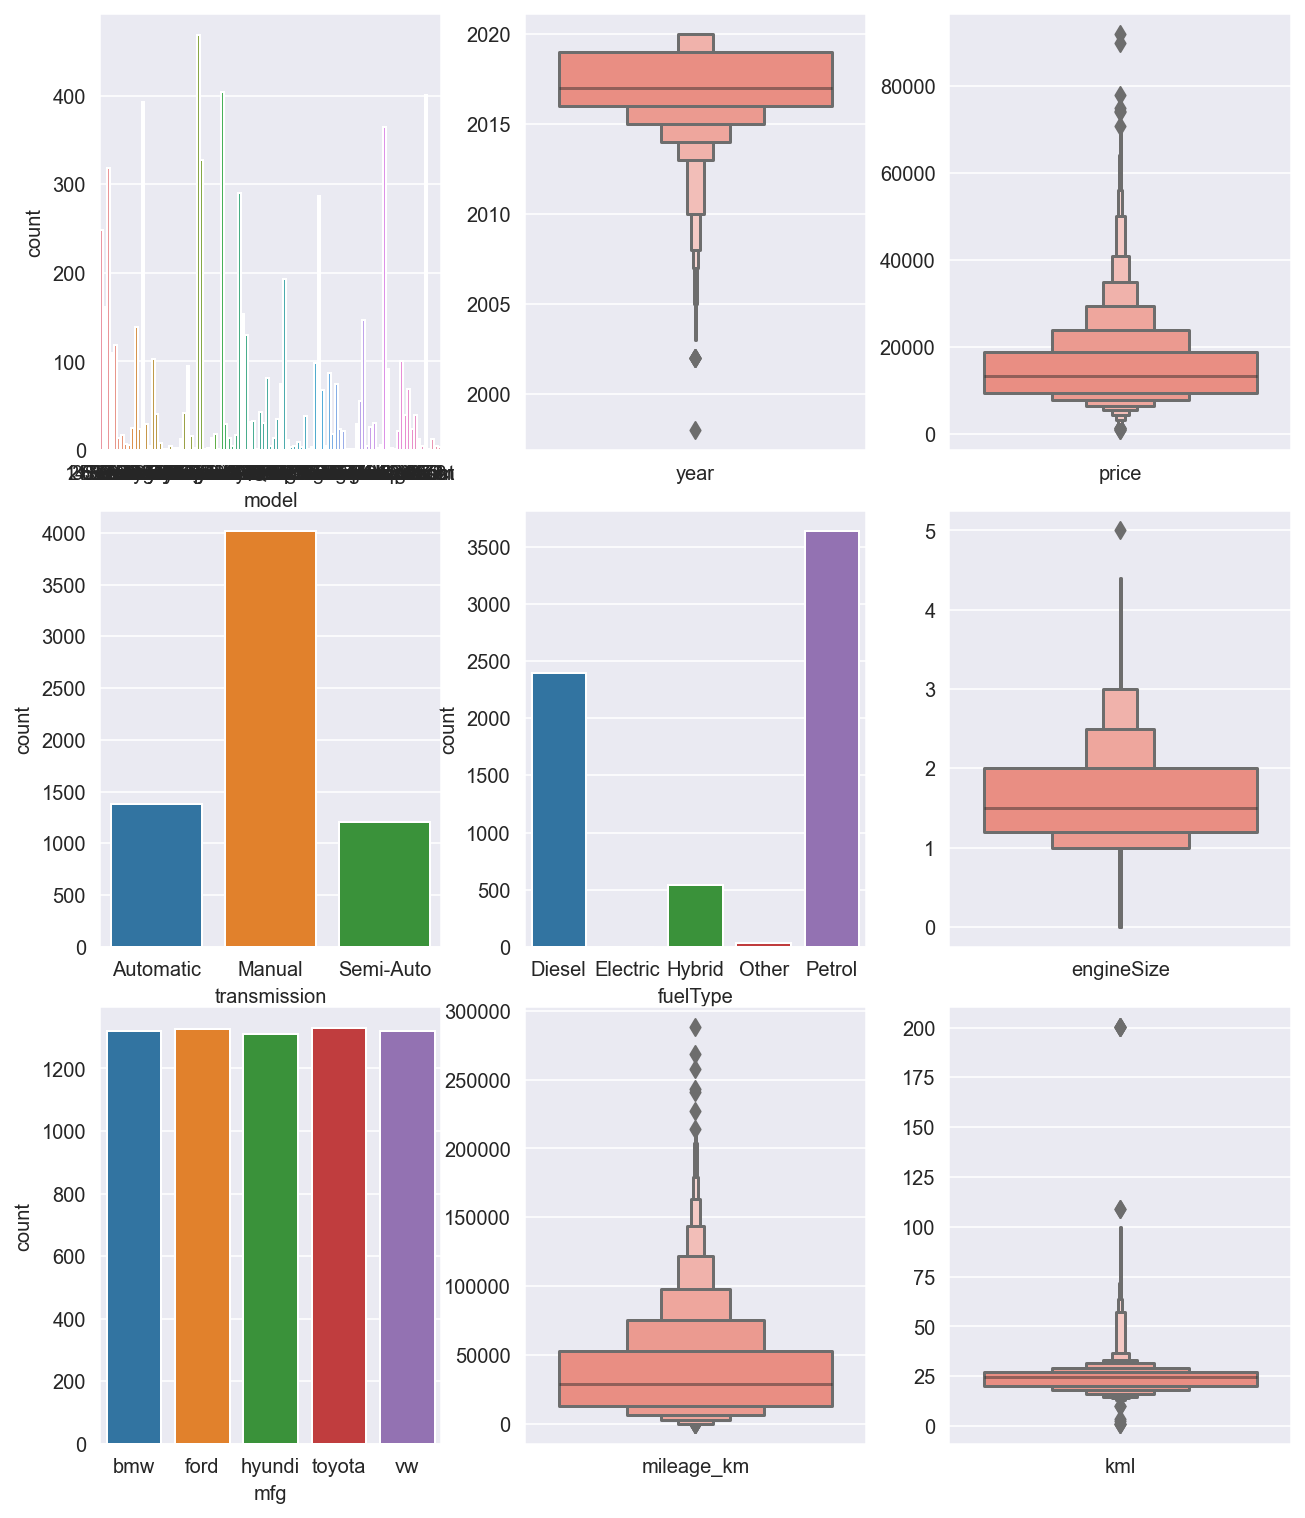

In [17]:
plot_mn(df, df.columns, 3, 'boxen')

## จากการสำรวจข้อมูลเบื้องต้นพบว่า
- จำนวนรถในปีเก่าๆจะมีน้อย(ดูจากกราฟคอลัมน์ year)
- ประมาณ 50% ของรถยนต์มือสองมีราคาไม่ถึง 20,000 ปอนด์
- FuelType มีอยู่ทั้งหมด 5 แบบ แต่ Electric, Hybrid และ other จะมีจำนวนค่อนข้างน้อย
- จากคอลัมน์ kml พบว่ามีรถยนต์จำนวนไม่น้อยที่มี kml เยอะมาก จนรู้สึกว่าผิดปกติ เราจึงจะลองดึงข้อมูลออกมาดูว่าเพราะอะไรที่ทำให้ kml ของรถยนต์บางคัน เยอะมากขนาดนั้น ?

In [18]:
df.sort_values('kml', ascending=False).head(10)

,model,year,price,transmission,fuelType,engineSize,mfg,mileage_km,kml
748,i3,2015.0,17481,Automatic,Hybrid,0.0,bmw,15909.93524,200.157657
268,i3,2017.0,21500,Automatic,Hybrid,0.0,bmw,17541.80600,200.157657
809,i3,2017.0,19495,Automatic,Hybrid,0.0,bmw,27902.73692,200.157657
387,i3,2017.0,19000,Automatic,Hybrid,0.0,bmw,38596.80122,200.157657
6479,Ioniq,2018.0,18970,Automatic,Hybrid,1.6,hyundi,23956.63524,109.176904
6596,Ioniq,2019.0,19995,Automatic,Hybrid,1.6,hyundi,11886.58524,109.176904
4021,Prius,2017.0,19998,Automatic,Hybrid,1.8,toyota,21687.46584,99.908771
5205,Prius,2019.0,24987,Automatic,Hybrid,1.8,toyota,10544.39568,99.908771
5260,Prius,2019.0,27999,Automatic,Hybrid,1.8,toyota,16053.16650,92.383728
5106,Prius,2019.0,28590,Automatic,Other,1.8,toyota,8046.70000,92.383728


## หลังจากดึงข้อมูลที่เรียงตาม kml ออกมาก็พบว่า
- เป็นรถยนต์ที่มี fuelType เป็น hybrid และมีการรับ engineSize ที่ไม่เหมือนรถยนต์คันอื่นๆที่อาจจะมีเครื่องยนต์แบบสันดาป ทำให้ไม่แฟร์ หากจะนำมาวิเคราะห์ในมาตรฐานเดียวกัน
- ดังนั้นเราจึงตัดสินใจที่จะวิเคราะห์แค่ในส่วนของ fuelType Diesel กับ Petrol

In [19]:
df.drop(df[df['fuelType']=='Other'].index,inplace=True)
df.drop(df[df['fuelType']=='Hybrid'].index,inplace=True)
df.drop(df[df['fuelType']=='Electric'].index,inplace=True)

In [20]:
df['fuelType'].value_counts()

Petrol      3635
Diesel      2395
Electric       0
Hybrid         0
Other          0
Name: fuelType, dtype: int64

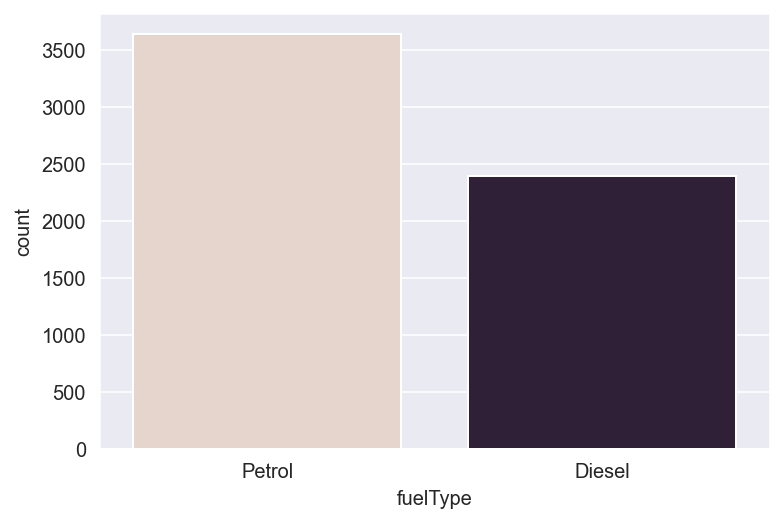

In [21]:
ax = sns.countplot(df.fuelType, palette="ch:.1", order=['Petrol','Diesel'])

In [22]:
df.reset_index(drop='True')

,model,year,price,transmission,fuelType,engineSize,mfg,mileage_km,kml
0,3 Series,2017.0,14990,Semi-Auto,Diesel,2.0,bmw,78220.36136,28.612172
1,2 Series,2020.0,26490,Semi-Auto,Diesel,2.0,bmw,16.09340,20.024269
2,X3,2019.0,38900,Semi-Auto,Diesel,3.0,bmw,5314.04068,20.704499
3,1 Series,2019.0,17980,Semi-Auto,Diesel,2.0,bmw,17174.87648,31.588177
4,3 Series,2015.0,11995,Semi-Auto,Petrol,2.0,bmw,84305.27590,20.024269
...,...,...,...,...,...,...,...,...,...
6025,I10,2019.0,9995,Manual,Petrol,1.0,hyundi,160.93400,21.087128
6026,I10,2017.0,7495,Manual,Petrol,1.0,hyundi,44890.92996,25.551137
6027,I40,2017.0,10995,Manual,Diesel,1.7,hyundi,48280.20000,28.612172
6028,I10,2017.0,6490,Manual,Petrol,1.0,hyundi,43304.12072,25.551137


In [23]:
df.columns

Index(['model', 'year', 'price', 'transmission', 'fuelType', 'engineSize',
       'mfg', 'mileage_km', 'kml'],
      dtype='object')

In [24]:
cols=['model', 'year', 'price', 'transmission', 'fuelType', 'engineSize',
       'mfg', 'mileage_km', 'kml']

## Correlation Heatmap

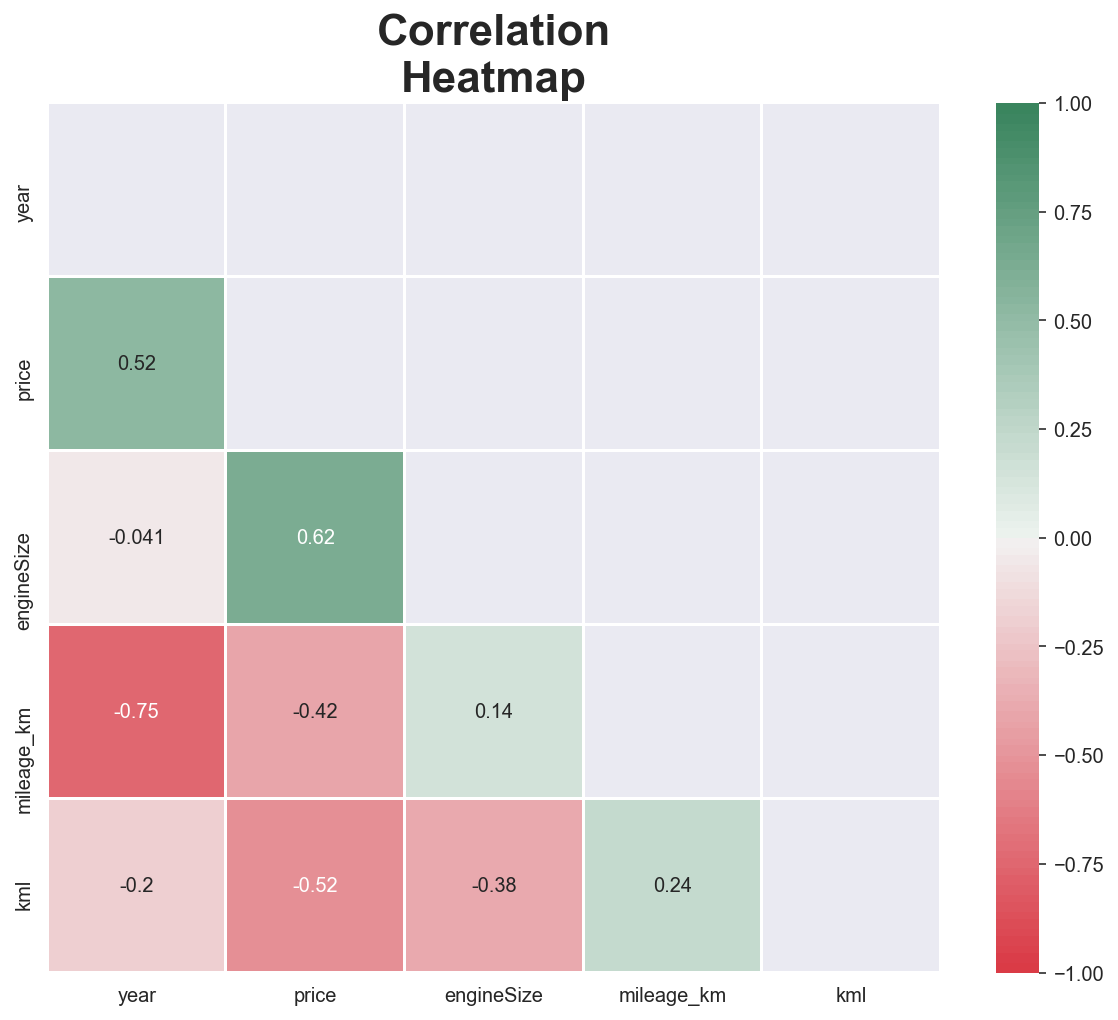

In [25]:
dcorr=df[cols].corr()
# dcorr

mask = np.zeros_like(dcorr)
# mask.shape
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(dcorr, cmap=sns.diverging_palette(10, 145, n=100), 
            vmin=-1, vmax=1, center=0, linewidths=1, annot=True, mask=mask, ax=ax).set_title("Correlation\nHeatmap", fontsize=22,fontweight="bold");

### ข้อสังเกตจาก
- รถยนต์มือสองที่ยังไม่เก่ามากมักจะมีราคาสูง สังเกตได้จาก correlation ที่ price กับ year มีค่าเท่ากับ 0.52
- ยิ่งรถใหม่ จำนวนขับมักจะน้อย สังเกตได้จาก correlation ที่ mileage_km กับ year มีค่าเท่ากับ -0.75 
- engineSize ใหญ่ ราคาจะสูง สังเกตได้จาก correlation ที่ price กับ engineSize มีค่าเท่ากับ 0.62
- ราคารถยนต์จะต่ำถ้ารถไม่ค่อยประหยัดน้ำมัน สังเกตได้จาก correlation ที่ price กับ year มีค่าเท่ากับ -0.52

# 3. ตั้งประเด็นคำถามที่น่าสนใจพร้อมสร้างและวิเคราะห์ข้อมูลด้วย machine learning model
### ประเด็นคำถามที่น่าสนใจคือ ตัวแปรสำคัญอะไรที่ส่งผลต่อราคารถยนต์มือสอง ? และด้วยตัวแปรที่มีจะนายราคารถยนต์มือสองได้เป็นราคาเท่าไหร่?
- โดยเราจะใช้ lightgbm Regressor ในการทำนายราคารถยนต์
- และใช้ Shap มาช่วยอธิบายและแสดงค่าความสำคัญของตัวแปร

## model

In [26]:
# ignore Date columns (use month and year instead)
feature_cols=['year','transmission', 'fuelType', 'engineSize',
       'mfg', 'mileage_km', 'kml']

target_col='price'
X=df[feature_cols]
y=df[target_col]

In [27]:
from sklearn.model_selection import train_test_split,cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [28]:
import lightgbm as lgb
print(f'lightgbm version = {lgb.__version__}')

lightgbm version = 3.1.1


In [29]:
reg = lgb.LGBMRegressor() 

In [30]:
reg.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [31]:
params={'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 5.0, 
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0
}
# reg = lgb.LGBMRegressor()
reg = lgb.LGBMRegressor(**params)

In [32]:
fit_params={'early_stopping_rounds':100, 
            'eval_set': [(X_test, y_test)],
            'verbose': 10,
           }
reg.fit(X_train, y_train, **fit_params) # with early_stopping and lgb.plot_metric

Training until validation scores don't improve for 100 rounds
[10]	valid_0's l2: 2.29424e+07
[20]	valid_0's l2: 1.34804e+07
[30]	valid_0's l2: 1.12093e+07
[40]	valid_0's l2: 1.05607e+07
[50]	valid_0's l2: 1.0238e+07
[60]	valid_0's l2: 1.013e+07
[70]	valid_0's l2: 1.00044e+07
[80]	valid_0's l2: 9.9589e+06
[90]	valid_0's l2: 9.93024e+06
[100]	valid_0's l2: 9.88768e+06
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 9.88372e+06


LGBMRegressor(reg_alpha=5.0)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

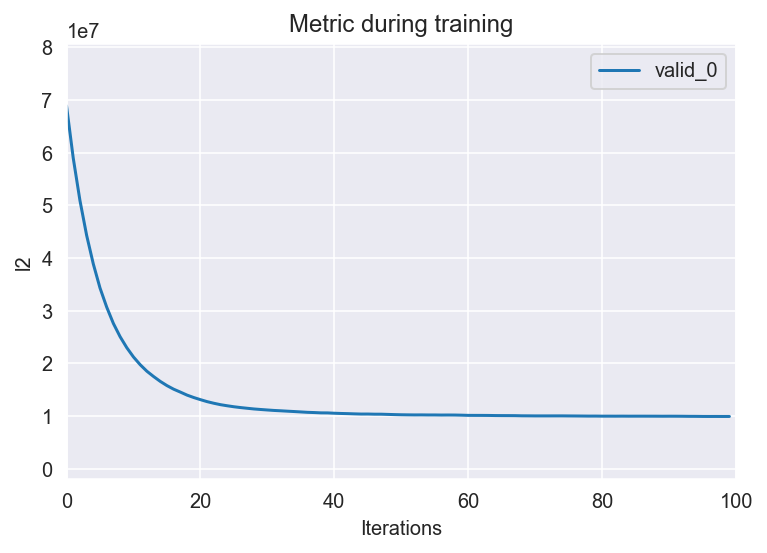

In [33]:
lgb.plot_metric(reg) #หลังจากเทรนด์ไปประมาณ 20 รอบ l2 ที่ได้ก็เริ่มคงที่

In [34]:
reg.score(X_train, y_train)

0.9547104550943709

In [35]:
reg.score(X_test, y_test)

0.8779781942546372

In [36]:
reg.predict(X_test[:5])

array([ 8165.06985501, 15583.23850216,  8430.73866868, 18958.99391224,
       10541.3593503 ])

### cross validation score

In [37]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2)
scores = cross_val_score(reg, X, y, cv=cv)
print(scores)
print(f'mean scores = {scores.mean()}, sd={scores.std():.4f}')                                         

[0.85660727 0.91523504 0.9304067  0.90902721 0.93161877]
mean scores = 0.9085789972287541, sd=0.0274


### explore decision trees

In [38]:
show_info=['split_gain', 'internal_value', 'data_percentage', 'leaf_count']
orientation='vertical'

max_num_trees=reg.__dict__['_Booster'].num_trees()
w_tree_index=widgets.BoundedIntText(
    value=0,
    min=0,
    max=max_num_trees-1,
    step=1,
    continuous_update=True,
)
w_max_depth=widgets.BoundedIntText(
    value=3,
    min=2,
    max=10,
    step=1,
    continuous_update=True,
)
w_n_estimators=widgets.BoundedIntText(
    value=3,
    min=1,
    max=100,
    step=1,
    continuous_update=True,
)
@interact
def plot_tree(tree_index=w_tree_index, orientation=['vertical', 'horizontal'], max_depth=w_max_depth, n_estimators=w_n_estimators, save_tree_img=[False, True]):
    params={
        'subsample': 1.0,
        'n_estimators': n_estimators,
        'max_depth': max_depth
    }
    reg = lgb.LGBMRegressor(**params)    
    reg.fit(X_train, y_train)
    case_index=1
    print(X_test.iloc[[case_index]])
    print(f'predicted value = {reg.predict(X_test.iloc[[case_index]])}')
    w_tree_index.max=w_n_estimators.value-1
    g=lgb.create_tree_digraph(reg, orientation=orientation, tree_index=tree_index, show_info=show_info, precision=4)
    if save_tree_img:
        g.format='png'
        g.render(f'tree{tree_index}', view=False, cleanup=True)
    return g

interactive(children=(BoundedIntText(value=0, continuous_update=True, description='tree_index', max=98), Dropd…

## SHAP
> SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

[<img src="https://shap.readthedocs.io/en/latest/_images/shap_header.png" width=800>](https://shap.readthedocs.io/en/latest/)
* doc: https://shap.readthedocs.io/en/latest/
* installation:
    * `pip install shap` or
    * `conda install -c conda-forge shap`

In [39]:
import shap
print(f'shap version {shap.__version__}')
# load JS visualization code to notebook
shap.initjs()

shap version 0.37.0


In [40]:
def case_detail(case_data):
    '''
    format obj returned from shap.force_plot()
    '''
    de=pd.DataFrame(case_data.data['features'])
    fcols=[]
    for i in case_data.data['features'].keys():
        fcols.append(case_data.data['featureNames'][i])
    de.columns=fcols
    return de

def individual_case_plot(explainer, X, case_index, verbose=False):
    """
    >>> individual_case_plot(explainer, X_train, 1)
    """
    shap_values = explainer.shap_values(X.iloc[[case_index]])
    g=shap.force_plot(explainer.expected_value, shap_values=shap_values, features=X.iloc[case_index, :])
    if verbose:
        pprint(g.__dict__)
    return g

In [41]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X)

In [42]:
X

,year,transmission,fuelType,engineSize,mfg,mileage_km,kml
0,2017.0,Semi-Auto,Diesel,2.0,bmw,78220.36136,28.612172
1,2020.0,Semi-Auto,Diesel,2.0,bmw,16.09340,20.024269
2,2019.0,Semi-Auto,Diesel,3.0,bmw,5314.04068,20.704499
3,2019.0,Semi-Auto,Diesel,2.0,bmw,17174.87648,31.588177
4,2015.0,Semi-Auto,Petrol,2.0,bmw,84305.27590,20.024269
...,...,...,...,...,...,...,...
6627,2019.0,Manual,Petrol,1.0,hyundi,160.93400,21.087128
6628,2017.0,Manual,Petrol,1.0,hyundi,44890.92996,25.551137
6629,2017.0,Manual,Diesel,1.7,hyundi,48280.20000,28.612172
6630,2017.0,Manual,Petrol,1.0,hyundi,43304.12072,25.551137


In [43]:
shap_values[:3]

array([[-1029.1902405 ,  1968.9585131 ,   603.47412789,  2343.95389332,
          881.9356107 , -2002.44904441, -2338.82989334],
       [ 5635.93366025,  2343.85001296,  1445.91420215,  3356.66759565,
         1341.88101142,  2219.75776384,  -438.53243272],
       [ 5595.17814321,  2993.14078035,  1383.02678872,  8566.67256501,
         3035.72156317,  2417.65411701, -3004.2245623 ]])

In [44]:
dshap=pd.DataFrame(shap_values, columns=feature_cols)
dshap

,year,transmission,fuelType,engineSize,mfg,mileage_km,kml
0,-1029.190241,1968.958513,603.474128,2343.953893,881.935611,-2002.449044,-2338.829893
1,5635.933660,2343.850013,1445.914202,3356.667596,1341.881011,2219.757764,-438.532433
2,5595.178143,2993.140780,1383.026789,8566.672565,3035.721563,2417.654117,-3004.224562
3,4358.643055,2108.863416,574.730016,2474.978234,1100.391597,-285.989700,-3931.735684
4,-3064.114336,2131.258089,-974.811730,2253.895491,1285.889524,-1716.003609,611.725976
...,...,...,...,...,...,...,...
6025,2424.449374,-1025.725322,-599.617994,-3517.553100,-2358.120798,824.106465,-145.941261
6026,-614.260793,-882.397887,-343.910650,-2939.647428,-1662.179052,-248.459542,-1120.551681
6027,-612.380702,-813.734418,658.107259,1025.870300,-986.554548,-340.399588,-1402.432745
6028,-612.088008,-880.208415,-342.828229,-2961.280239,-1673.810697,-225.308755,-1115.882689


### อธิบาย feature important ด้วย SHAP value
- แสดงถึงผลกระทบของแต่ละฟีเจอร์ต่อราคาของรถยนต์มือสอง
- บ่งบอกว่ากระทบระดับไหน แต่ไม่ได้บอกทิศทาง
- เห็นได้ชัดว่า engineSize และ year นั้นส่งผลต่อราคาเป็นอย่างมาก

In [45]:
# mean(abs(SHAP value)): average impact on model output magnitude
np.abs(dshap).mean().sort_values(ascending=False)

engineSize      2608.898016
year            2549.926991
kml             1377.424378
transmission    1309.632555
mfg             1064.621516
mileage_km       995.175021
fuelType         604.888818
dtype: float64

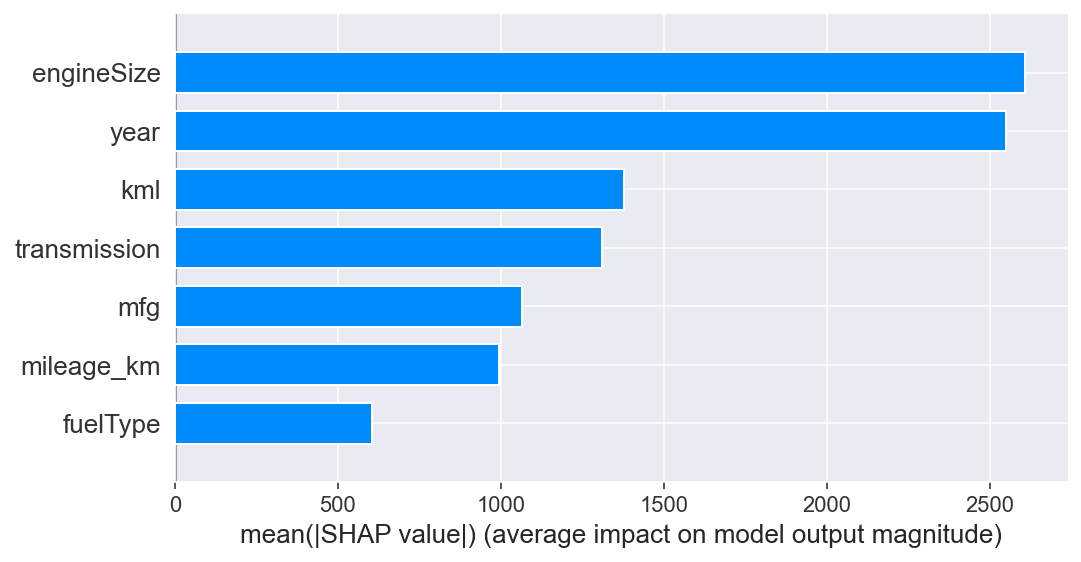

In [46]:
shap.summary_plot(dshap, X, plot_type="bar")

### อธิบายทิศทางที่กระทบต่อราคารถยนต์มือสองด้วย summary plot
- เนื่องจากว่าข้อมูลส่งผลทั้งบวกทั้งลบ
- จะเห็นได้ว่า สีแดงหมายถึงค่าของ feature สูง สีฟ้าหมายถึงค่า ต่ำ
- วิธีอ่าน plot นี้ก็คือ แกนจะถูกแบ่งครึ่งซ้ายขวา ถ้าช่วงข้อมูลไปตกอยู่ฝั่งขวาหมายถึง มีอิมแพคด้านบวก ถ้าไปตกอยู่ฝั่งซ้ายหมายถึง มีอิมแพคด้านลบ

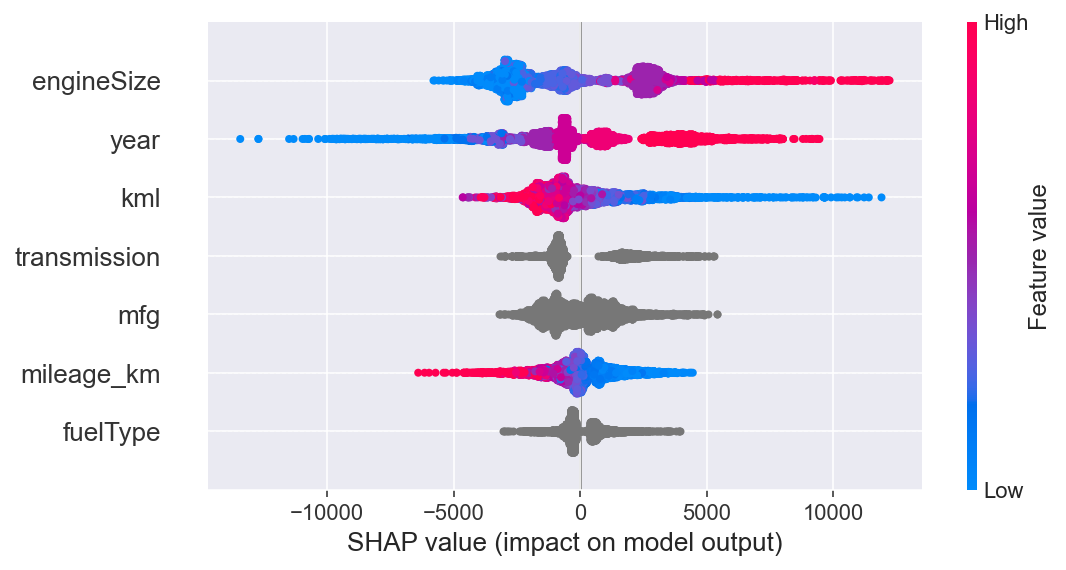

In [47]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

# สรุปได้ว่า
- เราสร้างโมเดลทำนายราคารถยนต์มือสองด้วย Lightgbm Regressor ด้วยฟีเจอร์ year, transmission, fuelType, engineSize, mfg, mileage_km และ kml
- cross validation score ได้เท่ากับ 0.9157
- 3 feature ที่มีอิมแพคมากที่สุดได้แก่ engineSize, year และ kml
- engineSize ที่เยอะมักส่งผลให้ราคาเยอะตาม
- year รถยนต์ปีเก่าๆมักส่งผลให้ราคารถยนต์ไม่ค่อยสูง
- kml รถยนต์ที่ประหยัดน้ำมันมักมีราคาที่สูง


----------------------------------------------------------------------------------------------------